# Import Dependencies

In [8]:
# System
import os

# Data Analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix

import tensorflow as tf

import pickle

# Get Data

In [3]:
file_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/cutfree-simulations/runtime_data_v2.csv"
df_original = pd.read_csv(file_path)
df = df_original.copy()
df.iloc[0]

Oligo                        NNNNNN
OligoLength                       6
Sites                   Any["YATR"]
TotalSites                        1
SiteLength                        4
CutFree_Randomer             NBNVVN
CutFree_Degeneracy          7.45472
CutFree_Time               0.006211
CutFreeRL_Randomer           NNVVVN
CutFreeRL_Degeneracy        7.45472
CutFreeRL_Time             0.228063
Name: 0, dtype: object

In [4]:
conditions = [
    (df["CutFree_Time"] > 60),
    (df["CutFree_Time"] <= 60)
]

values = [0, 1] # 0 = Reject, 1 = Accept

df["Allow"] = np.select(conditions, values)

# Rejection Sampling

In [5]:
numCutFree = df[df.Allow == 0].shape[0]
print(numCutFree)

numCutFreeRL = df[df.Allow == 1].shape[0]
print(numCutFreeRL)

563
4686


In [6]:
df_rejection = df[df.Allow == 1].sample(numCutFreeRL-numCutFree, random_state=4)
df = df.drop(df_rejection.index)

In [7]:
numCutFree = df[df.Allow == 0].shape[0]
print(numCutFree)

numCutFreeRL = df[df.Allow == 1].shape[0]
print(numCutFreeRL)

563
563


In [8]:
df_total = df.copy()
df = df[["OligoLength", "TotalSites", "SiteLength", "Allow"]]
df

,OligoLength,TotalSites,SiteLength,Allow
0,6,1,4,1
6,6,7,4,1
9,6,10,4,1
12,6,3,5,1
16,6,7,5,1
...,...,...,...,...
5243,40,5,8,0
5245,40,7,8,0
5246,40,8,8,0
5247,40,9,8,0


# Visualize Data

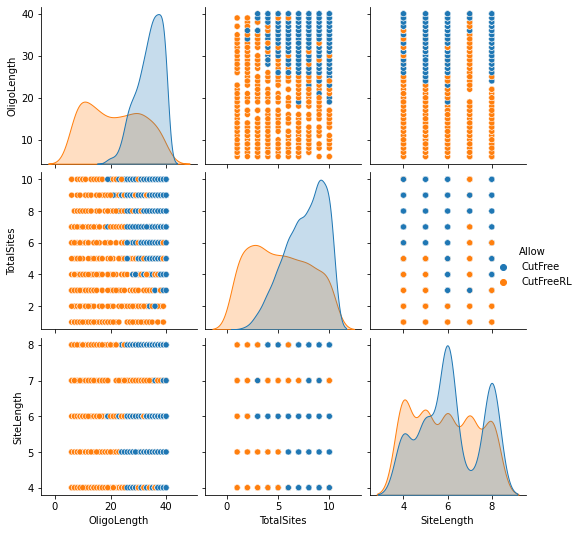

In [9]:
pair_plot = sns.pairplot(df, hue="Allow", diag_kind="kde")
new_labels = ["CutFree", "CutFreeRL"]
for t, l in zip(pair_plot._legend.texts, new_labels):
    t.set_text(l)
plt.show(pair_plot)

# Get Train/Test Split

In [10]:
x = df.drop(["Allow"], axis=1)
y = df["Allow"]

In [11]:
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x, y, test_size=0.2, random_state=1)
x_train_df.head()

,OligoLength,TotalSites,SiteLength
4676,29,8,6
1377,33,8,6
1291,31,2,8
4218,20,9,5
4600,28,1,4


In [12]:
y_train_df.head()

4676    1
1377    0
1291    1
4218    1
4600    1
Name: Allow, dtype: int32

In [13]:
x_train, y_train = tf.convert_to_tensor(x_train_df, dtype=tf.float32), tf.convert_to_tensor(y_train_df, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test_df, dtype=tf.float32), tf.convert_to_tensor(y_test_df, dtype=tf.float32)

In [14]:
x_train

<tf.Tensor: shape=(900, 3), dtype=float32, numpy=
array([[29.,  8.,  6.],
       [33.,  8.,  6.],
       [31.,  2.,  8.],
       ...,
       [39., 10.,  6.],
       [35.,  9.,  5.],
       [37.,  5.,  8.]], dtype=float32)>

# Machine Learning

In [15]:
def get_accuracy(pred, true):
    test_accuracy = accuracy_score(pred, true)*100
    print("Accuracy: {:.2f}%".format(test_accuracy))
    return test_accuracy

### MLP Classifier NN

In [16]:
class_NN = MLPClassifier(
    hidden_layer_sizes=(32, 8, 32, 32, 32, 32),
    activation='relu',
    solver='adam',
    momentum=0.815,
    alpha=0.0005,
    learning_rate='adaptive',
    max_iter=1000, 
    verbose=0,
    random_state=1)
class_NN.fit(x_train, y_train)

MLPClassifier(alpha=0.0005, hidden_layer_sizes=(32, 8, 32, 32, 32, 32),
              learning_rate='adaptive', max_iter=1000, momentum=0.815,
              random_state=1, verbose=0)

In [17]:
y_pred = class_NN.predict(x_test)
mlp_acc = get_accuracy(y_pred, y_test)

Accuracy: 86.28%


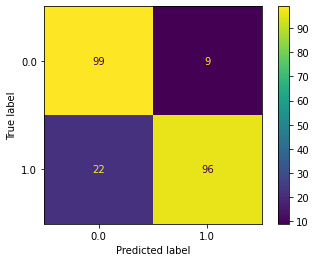

In [18]:
plot_confusion_matrix(class_NN, x_test, y_test)  
plt.show()

In [19]:
print(classification_report(y_pred, y_test, target_names=["Reject", "Accept"]))

              precision    recall  f1-score   support

      Reject       0.92      0.82      0.86       121
      Accept       0.81      0.91      0.86       105

    accuracy                           0.86       226
   macro avg       0.87      0.87      0.86       226
weighted avg       0.87      0.86      0.86       226



In [20]:
df_total = df_total[["OligoLength", "TotalSites", "SiteLength", "Allow", "CutFree_Time"]]
df_total.head()

,OligoLength,TotalSites,SiteLength,Allow,CutFree_Time
0,6,1,4,1,0.006211
6,6,7,4,1,0.018870
9,6,10,4,1,0.021175
12,6,3,5,1,0.009898
16,6,7,5,1,0.026725


In [21]:
df_total = df_total.sort_values(by=["CutFree_Time"], ascending=True)
df_total.head()

,OligoLength,TotalSites,SiteLength,Allow,CutFree_Time
140,8,1,8,1,0.004827
91,7,2,8,1,0.004833
190,9,1,8,1,0.005403
32,6,3,7,1,0.005651
80,7,1,7,1,0.005708


In [22]:
df_total.loc[x_test_df.index[np.where(y_test_df != y_pred)], "Prediction"] = 0
df_total.loc[df_total["Prediction"].isna(), "Prediction"] = 1

In [23]:
df_total = df_total.reset_index(drop=True)
df_total.head()

,OligoLength,TotalSites,SiteLength,Allow,CutFree_Time,Prediction
0,8,1,8,1,0.004827,1.0
1,7,2,8,1,0.004833,1.0
2,9,1,8,1,0.005403,1.0
3,6,3,7,1,0.005651,1.0
4,7,1,7,1,0.005708,1.0


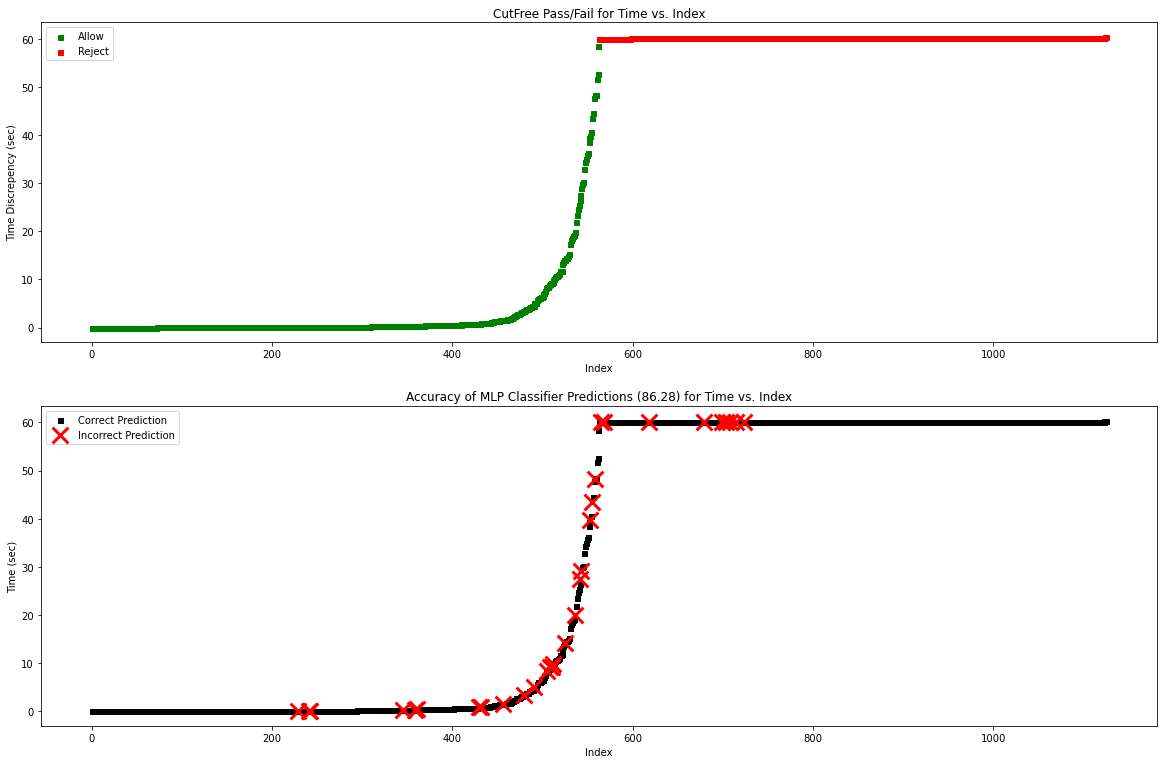

In [24]:
plt.figure(figsize=(20,20))

plt.subplot(311)

plt.scatter(
    df_total[df_total.Allow==1].index, df_total[df_total.Allow==1].CutFree_Time, 
    c ="green",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.scatter(
    df_total[df_total.Allow==0].index, df_total[df_total.Allow==0].CutFree_Time, 
    c ="red",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.title("CutFree Pass/Fail for Time vs. Index")
plt.xlabel("Index")
plt.ylabel("Time Discrepency (sec)")
plt.legend(["Allow", "Reject"])

plt.subplot(312)
plt.scatter(
    df_total[df_total.Prediction==1].index, df_total[df_total.Prediction==1].CutFree_Time, 
    c ="black",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.scatter(
    df_total[df_total.Prediction==0].index, df_total[df_total.Prediction==0].CutFree_Time, 
    c ="red",
    linewidths = 3,
    marker ="x",
    s = 250)

plt.title(f"Accuracy of MLP Classifier Predictions ({mlp_acc:.2f}) for Time vs. Index")
plt.xlabel("Index")
plt.ylabel("Time (sec)")
plt.legend(["Correct Prediction", "Incorrect Prediction"])

# Save Model

In [25]:
with open("cutfree_runtime_classification_model.pkl", "wb") as f:
    pickle.dump(class_NN, f)

In [27]:
with open("../cutfree-models/cutfree_runtime_classification_model.pkl", "rb") as f:
    model = pickle.load(f)
model.predict([[6, 1, 4]])

array([1.], dtype=float32)